# The non-commutativity of gradient steps is a fundamental limitation of exact unlearning

This notebook perform the experiments presented in the [associated paper](./commutativity.md).

## Preliminaries

### Imports

In [1]:
from __future__ import annotations

from copy import deepcopy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
import torch
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules.loss import _Loss, CrossEntropyLoss
from torch.optim import Optimizer, SGD, Adam, AdamW
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset, random_split
import torchvision
from torchvision.datasets import CIFAR10
from torchvision.transforms import v2 as T
from torchmetrics.classification import MulticlassAccuracy
import torchinfo
from image_classification.cifar_models.resnet import ResNet18

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


### Datasets

In [3]:
transform = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

batch_size = 64

train_set = CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

classes = train_set.classes

In [4]:
def denorm(batch: Tensor, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    device = batch.device

    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

### Network architecture

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#net = Net().to(device)

In [6]:
net = ResNet18(num_classes=10).to(device)

### Hyperparameters

In [7]:
lr = 0.001
weight_decay = 5e-5

def make_optimizer(model: nn.Module) -> Optimizer:
    return Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

criterion = nn.CrossEntropyLoss()
optimizer = make_optimizer(net)
epochs = 2

### Pre-train the model

In [8]:
def train_loop(model: nn.Module, train_loader: DataLoader, criterion: _Loss, optimizer: Optimizer, epochs: int):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 200 == 199:
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
                running_loss = 0.0

    print('Finished Training')
    model.eval()

def test_loop(model: nn.Module, test_loader: DataLoader, criterion: _Loss,):
    model.eval()
    correct = 0
    total = 0
    loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss += criterion(outputs, labels)

            predicted = outputs.argmax(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Test accuracy on {total} samples: {100 * correct // total} %')
    print(f'Average loss: {loss / len(test_loader):.2}')

In [9]:
train_loop(net, train_loader, criterion, optimizer, epochs)

[1,   200] loss: 1.763
[1,   400] loss: 1.390
[1,   600] loss: 1.187
[2,   200] loss: 0.944
[2,   400] loss: 0.892
[2,   600] loss: 0.826
Finished Training


In [10]:
test_loop(net, test_loader, criterion)

Test accuracy on 10000 samples: 68 %
Average loss: 0.92


## Gradient ascent does not revert gradient descent

We show that gradient ascent makes the model diverge. Approaches like NegGrad+ can maintain the accuracy but do not prevent divergence.

In [11]:
def model_to_tensor(model: nn.Module) -> Tensor:
    """
    Convert the model parameters to a 1D tensor.
    """
    params = [
        param.detach().flatten()
        for param in model.parameters()
    ]
    return torch.cat(params)

def model_gradients(model: nn.Module) -> Tensor:
    """
    Convert the model parameter gradients to a 1D tensor.
    """
    params = [
        param.grad.detach().flatten()
        for param in model.parameters()
    ]
    return torch.cat(params)

In [12]:
def diff_g1_g2(
        model: nn.Module,
        criterion: _Loss, optimizer: Optimizer,
        batch_size=1, sep_batch_size=8, num_batches_between=500,
        limit=50):

    rows = []

    state_dict = deepcopy(model.state_dict())

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
    
    for _, (X1, y1) in zip(range(limit), train_loader):
        X1, y1 = X1.to(device), y1.to(device)

        model.train()
        # Perform gradient descent on a single data point
        optimizer.zero_grad()
        outputs = model(X1)
        loss = criterion(outputs, y1)
        loss.backward()
        l = loss.item()

        # Compute the loss gradient
        g1 = model_gradients(model)
        optimizer.step()
        optimizer.zero_grad()


        # Perform gradient descent on some other data points
        interleaved_loader = DataLoader(test_set, batch_size=sep_batch_size)
        for _, (X2, y2) in zip(range(num_batches_between), interleaved_loader):
            X2, y2 = X2.to(device), y2.to(device)
            y = model(X2)
            loss = criterion(y, y2)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        model.eval()
        y = model(X1)
        loss = criterion(y, y1)
        loss.backward()
        # Compute the loss gradient on the same data point
        g2 = model_gradients(model)


        n1 = g1.norm(p=2)
        n2 = g2.norm(p=2)
        cos_sim = torch.cosine_similarity(g1, g2, dim=0).item()
        norm_ratio = (n1 / n2).item()
        rel_diff = ((g2 - g1).norm(p=2) / n1).item()

        rows.append((l, norm_ratio, cos_sim, rel_diff))

        # FIXME: does optimizer still reference the model parameters?
        # Reset the model to its initial state
        model.load_state_dict(state_dict)
        model.eval()

    return pd.DataFrame(rows, columns=['loss', 'norm_ratio', 'cos_sim', 'rel_diff'])

In [13]:
def show_gradient_differences(net, criterion, optimizer, batch_size=1, sep_batch_size=8, num_batches_between=500):
    g1_g2_data = diff_g1_g2(
        net, criterion, optimizer,
        batch_size, sep_batch_size=sep_batch_size, num_batches_between=num_batches_between,
    )
    g1_g2_data = g1_g2_data[np.isfinite(g1_g2_data['rel_diff'])]

    fig, axes = plt.subplots(2, 2)
    
    if (g1_g2_data['norm_ratio'] > 5).any():
        sns.boxplot(g1_g2_data, y='norm_ratio', ax=axes[0, 0], log_scale=True)
    else:
        axes[0, 0].hist(g1_g2_data['norm_ratio'])
    
    axes[0, 0].set_xlabel('Gradients norm ratio')

    sns.boxplot(g1_g2_data, x='cos_sim', ax=axes[0, 1])
    axes[0, 1].set_xlabel('Gradients cosine similarities')

    sns.boxplot(g1_g2_data, y='rel_diff', ax=axes[1, 0])
    axes[1, 0].set_xlabel('Gradients relative difference')

    #axes[1, 1].scatter(g1_g2_data['cos_sim'], g1_g2_data['loss'])
    #axes[1, 1].set_xlabel('Gradients cosine similarity')
    #axes[1, 1].set_ylabel('Loss value (first gradient)')
    #axes[1, 1].set_title(f'Correlation: {np.corrcoef(g1_g2_data['cos_sim'], g1_g2_data['loss'])[0, 1]:.2f}')
    fig.suptitle(
        f'Gradient difference before and after gradient step\n'
        f'(batch size = {batch_size}, sep batch size = {sep_batch_size}, num batches between = {num_batches_between})'
    )
    fig.tight_layout()
    plt.show()

In [14]:
def plot_gradient_sim_against_sep_batches(
        net, criterion, optimizer,
        batch_size=1, sep_batch_size=8, max_num_batches_between=500,
        title='ResNet-18',
    ):
    num_batches_between = 2**np.arange(0, int(np.log2(max_num_batches_between) + 0.999), dtype=int)
    N = len(num_batches_between)
    quantiles = np.zeros((N, 5))

    for (i, n) in enumerate(num_batches_between):
        g1_g2_data = diff_g1_g2(
            net, criterion, optimizer,
            batch_size, sep_batch_size=sep_batch_size, num_batches_between=n,
        )
        g1_g2_data = g1_g2_data[np.isfinite(g1_g2_data['rel_diff'])]
        sims = g1_g2_data['cos_sim']
        
        quantiles[i, 0] = np.quantile(sims, 0.1)
        quantiles[i, 1] = np.quantile(sims, 0.25)
        quantiles[i, 2] = np.quantile(sims, 0.5)
        quantiles[i, 3] = np.quantile(sims, 0.75)
        quantiles[i, 4] = np.quantile(sims, 0.9)

    if max_num_batches_between > 50:
        plt.xscale('log')
        #plt.gca().ticklabel_format(axis='x', style='plain', useOffset=False)


    plt.plot(num_batches_between, quantiles[:, 2])
    plt.fill_between(num_batches_between, quantiles[:, 1], quantiles[:, 3], alpha=0.2)
    plt.fill_between(num_batches_between, quantiles[:, 0], quantiles[:, 4], alpha=0.1)
    
    plt.xlabel('Number of batches between gradients')
    plt.ylabel('Gradients cosine similarities')

    plt.title(title)
    plt.suptitle(
        f'Gradient similarity before and after gradient steps\n'
        f'(batch size = {batch_size}, sep batch size = {sep_batch_size}, learning rate = {lr})'
    )
    plt.tight_layout()
    plt.show()

    return quantiles

In [15]:
untrained_net = ResNet18(num_classes=10).to(device)

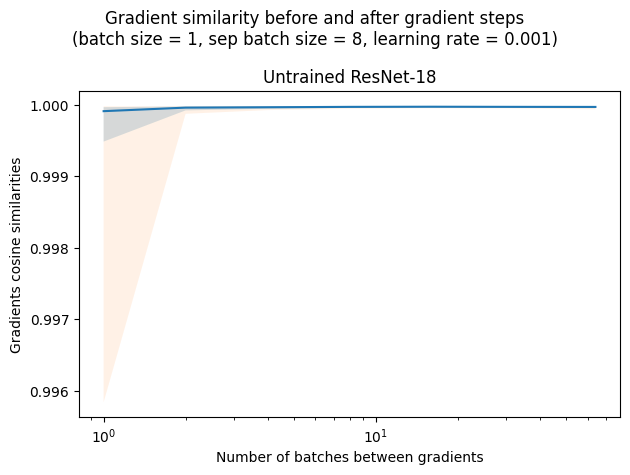

array([[0.99583713, 0.9994884 , 0.99991456, 0.99997044, 0.99998122],
       [0.9998777 , 0.99992523, 0.999964  , 0.99998003, 0.99998553],
       [0.99992936, 0.9999482 , 0.99996939, 0.99998097, 0.99998552],
       [0.99994795, 0.99995989, 0.99997464, 0.99998321, 0.99998717],
       [0.99995477, 0.99996471, 0.99997666, 0.99998416, 0.99998753],
       [0.9999526 , 0.99996269, 0.99997488, 0.99998309, 0.9999866 ],
       [0.99994062, 0.99995753, 0.99997383, 0.99998045, 0.99998474]])

In [16]:
plot_gradient_sim_against_sep_batches(
    untrained_net, criterion, optimizer,
    batch_size=1, max_num_batches_between=100,
    title='Untrained ResNet-18',
)

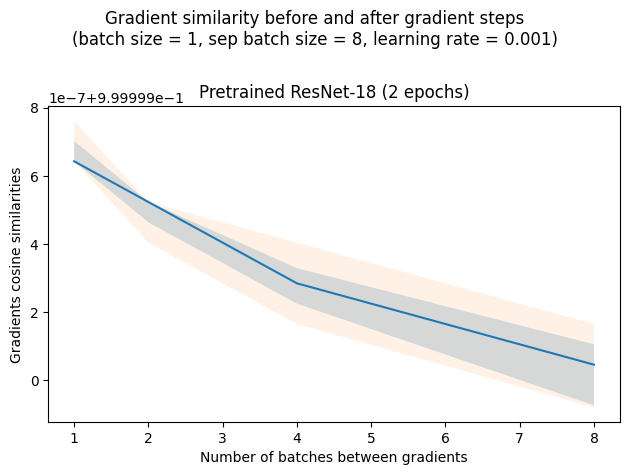

In [17]:
quantiles = plot_gradient_sim_against_sep_batches(
    untrained_net, criterion, optimizer,
    batch_size=1, max_num_batches_between=10,
    title=f'Pretrained ResNet-18 ({epochs} epochs)',
)

In [18]:
quantiles

array([[0.99999964, 0.99999964, 0.99999964, 0.9999997 , 0.99999976],
       [0.9999994 , 0.99999946, 0.99999952, 0.99999952, 0.99999952],
       [0.99999917, 0.99999923, 0.99999928, 0.99999933, 0.9999994 ],
       [0.99999892, 0.99999893, 0.99999905, 0.99999911, 0.99999917]])

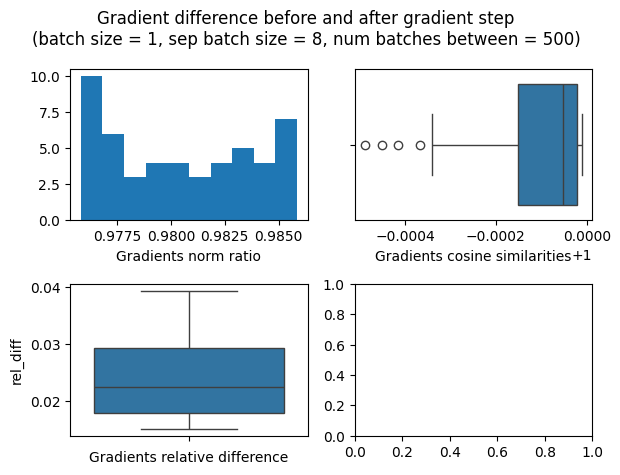

In [19]:
show_gradient_differences(untrained_net, criterion, optimizer, batch_size=1)

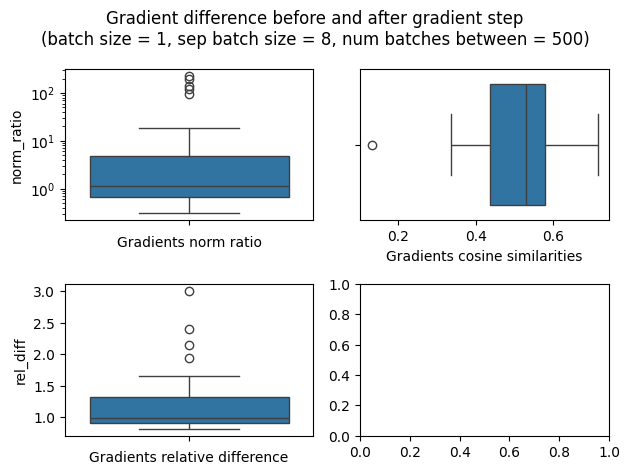

In [20]:
show_gradient_differences(net, criterion, optimizer, batch_size=1)

In [50]:
show_gradient_differences(net, criterion, optimizer, batch_size=2)

KeyboardInterrupt: 

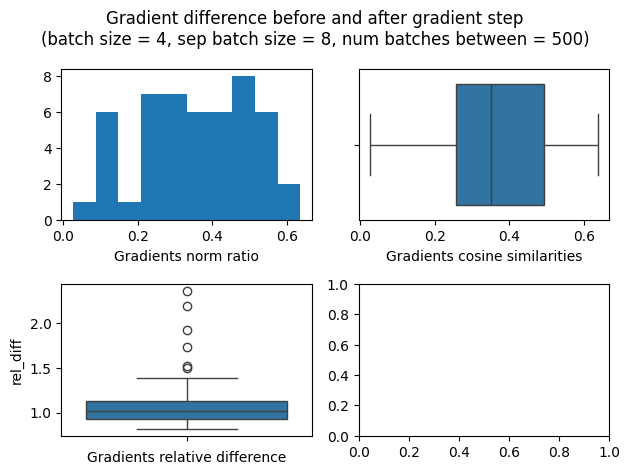

In [ ]:
show_gradient_differences(net, criterion, optimizer, batch_size=4)

In [ ]:
show_gradient_differences(net, criterion, optimizer, batch_size=16)

KeyboardInterrupt: 

In [ ]:
show_gradient_differences(net, criterion, optimizer, batch_size=64)

KeyboardInterrupt: 

In average, consecutive gradients on the same point have a cosine similarity of $0.5$ with batch size $64$, which represents an angle of $\frac{\pi}{3}$. With batch size $1$, the average similarity is $0.2$, with lots of outliers. In large dimensions, this is a high correlation. However, an attacker might craft points so that the similarity approaches zero. Furthermore, what about gradients separated by a whole batch?

## Gradient ascent is vulnerable to high-loss poisons

We show that machine unlearning fails to remove adversarial poisons, even when there are 10 poisons (deinterleaved) !

FIXME: the current attack requires an attacker with access to the weights, which might not be necessary since adversarial examples have high transferability across vision models.

### Adversarial example generation

We perform the FGSM attack in order to generate high-loss samples.

FIXME: this is abusing the GUS test by using a cherry-picked example?

In [ ]:
def make_adversarial_example(
        model: nn.Module, input: Tensor, label: Tensor,
        criterion: _Loss, epsilon=0.05
    ) -> Tensor:
    model.eval()
    # IMPORTANT: detach the input to avoid gradient accumulation
    input = input.detach().to(device).requires_grad_()
    output = model(input)
    loss = criterion(output, label.to(device))
    loss.backward()
    # FGSM attack, gaussian-revisited to better fit the GUS test
    perturbed = input + epsilon * torch.randn_like(input).copysign(input.grad)
    input.requires_grad_(False)
    return perturbed.detach().clamp(-1, 1)

In [ ]:
def make_adversarial_dataset(
        model: nn.Module, source: Dataset,
        criterion: _Loss, epsilon=0.05, limit=1000 #, fraction=1.0, 
    ) -> tuple[Dataset, Dataset, Dataset]:
    adv_inputs = []
    labels = []
    noise = []

    source_loader = DataLoader(source, batch_size=1, shuffle=False)
    for _, (input, label) in zip(range(limit), source_loader):
        #if np.random.rand() < fraction:
        adv_input = make_adversarial_example(model, input, label, criterion, epsilon)
        adv_input = adv_input.squeeze().to('cpu')
        adv_inputs.append(adv_input)
        noise.append(adv_input - input.squeeze())
        #else:
        #    # Add a non-corrupted, legitimate example.
        #    # FIXME: should we add harmlinoffensiveess gaussian noise?
        #    adv_inputs.append(input.squeeze().to('cpu'))
        #    noise.append(torch.zeros_like(adv_inputs[-1]))
        labels.append(label.squeeze())
    
    base_set = Subset(source, list(range(len(adv_inputs))))
    noise_set = TensorDataset(torch.stack(noise))
    adversarial_set = TensorDataset(torch.stack(adv_inputs), torch.stack(labels))

    return base_set, adversarial_set, noise_set

We create a dataset of **640** adversarial examples.

In [ ]:
# Make a multiple of the batch size for easier batched reverse iteration
num_adversarial = batch_size * 10
num_clean = len(train_set) - num_adversarial
adversarial_proportion = num_adversarial / len(train_set)
print(f'Generating {num_adversarial} adversarial examples ({100*adversarial_proportion:.3} %)')

adversarial_source, clean_set = random_split(train_set, [num_adversarial, num_clean])

base_set, adversarial_set, noise = make_adversarial_dataset(
    net, adversarial_source,
    criterion, limit=num_adversarial,
)

# FIXME:
corrupted_set = base_set + clean_set

clean_loader = DataLoader(clean_set, batch_size=batch_size)
adversarial_loader = DataLoader(adversarial_set, batch_size=batch_size)
corrupted_loader = DataLoader(corrupted_set, batch_size=batch_size)

Generating 640 adversarial examples (1.28 %)


#### Inspecting the adversarial examples

In [ ]:
def display_image(input: Tensor, label: Tensor, predicted: Tensor, ax: plt.Axes):
    image = denorm(input).numpy(force=True).squeeze().transpose(1, 2, 0)
    ax.imshow(image, interpolation='nearest')
    ax.set_title(f'Label: {classes[label]}, predicted: {classes[predicted]}', fontsize=7)

In [ ]:
def show_adversarial_prediction(
        model: nn.Module,
        adversarial_set: Dataset, base_set: Dataset,
        n: int,
    ):
    
    fig, axes = plt.subplots(2, n)
    fig.set_size_inches(13., 4.)

    for i in range(n):
        poisoned_input, label = adversarial_set[i]
        clean_input, _ = base_set[i]

        predicted = model(clean_input.to(device)[None, :]).argmax(1)
        display_image(clean_input, label, predicted, ax=axes[0, i])

        predicted = model(poisoned_input.to(device)[None, :]).argmax(1)
        display_image(poisoned_input, label, predicted, ax=axes[1, i])

    fig.tight_layout()

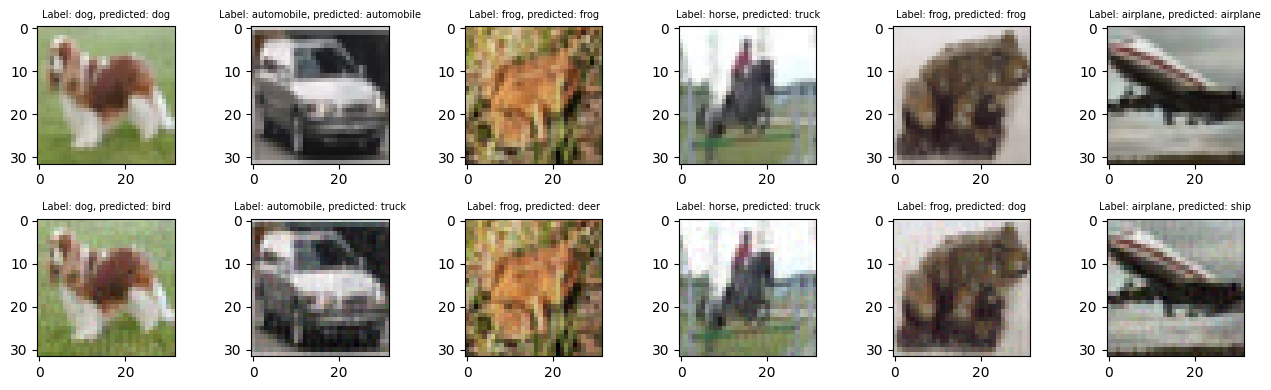

In [ ]:
show_adversarial_prediction(net, adversarial_set, base_set, 6)

In [ ]:
test_loop(net, adversarial_loader, criterion)

Test accuracy on 640 samples: 8 %
Average loss: 4.3


In [ ]:
test_loop(net, test_loader, criterion)

Test accuracy on 10000 samples: 76 %
Average loss: 0.67


The clean model accuracy is very low on adversarial examples, but unaffected on the test set.

In [ ]:
noise_mean = noise.tensors[0].mean().item()
noise_std = noise.tensors[0].std().item()
noise_mean, noise_std

(-0.0002519252884667367, 0.04953329265117645)

#### Noise normality quickcheck

We verify that the generated noise looks gaussian-distributed.

NormaltestResult(statistic=2.7405838869533596, pvalue=0.25403278551142044)

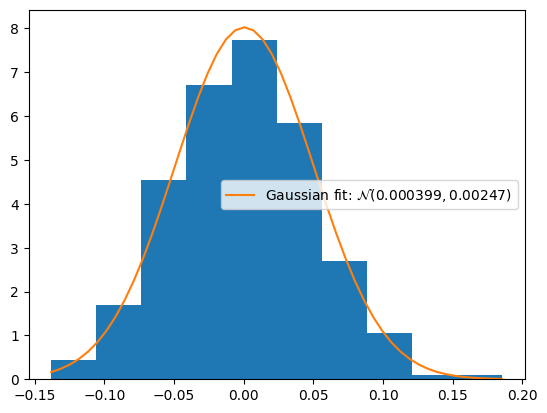

In [ ]:
from scipy import stats

pseudo_gaussian = noise.tensors[0][:, 1, 14, 21]
plt.hist(pseudo_gaussian, density=True)

mean = pseudo_gaussian.mean()
std = pseudo_gaussian.std()
distr = stats.norm(mean, std)
span = np.linspace(pseudo_gaussian.min(), pseudo_gaussian.max())
plt.plot(span, distr.pdf(span), label=fr'Gaussian fit: $\mathcal{{N}}({mean:.3}, {std**2:.3})$')
plt.legend()

stats.normaltest(noise.tensors[0][:, 1, 14, 21])

### GUS

We use the Gaussian Unlearning Score to evaluate unlearning. This slightly works since the noise is quasi-gaussian.

In [ ]:
from image_classification.unlearning import gradient_ascent, neg_grad_plus
from image_classification.gaussian_poisoning import gaussian_unlearning_score

def evaluate_unlearning(
        model: nn.Module,
        base_data: Dataset,
        noise: Dataset,
        noise_std: float,
        loss_fn: _Loss,
        xi_name=r'$\xi$', g_name='g', method='',
    ):
    I_poison = gaussian_unlearning_score(
        model,
        base_data,
        noise,
        noise_std,
        loss_fn,
    )

    mean = I_poison.mean()
    std = I_poison.std()

    mean_std_theory = 1. / np.sqrt(float(len(noise)))

    plt.hist(I_poison, density=True)

    iz = np.linspace(I_poison.min(), I_poison.max())
    distr = stats.norm(mean, std)
    plt.plot(iz, distr.pdf(iz), label=fr'Gaussian fit: $\mathcal{{N}}({mean:.3}, {std**2:.3})$')
    
    distr = stats.norm(0.0, 1.0)
    plt.plot(iz, distr.pdf(iz), label=fr'Theory: $\mathcal{{N}}(0 \pm {mean_std_theory:.3g}, 1)$')

    plt.xlabel(fr'$\mathcal{{I}}_{{\mathrm{{poison}}}} = \frac{{\langle \xi, {g_name} \rangle}}{{\epsilon ||{g_name}||_2}}$')
    plt.title(fr'Normalized dot product distribution between input gradients ${g_name}$ and {xi_name}')
    if method:
        plt.suptitle(method)
    plt.legend()
    plt.show()

### No poisoning

For reference, we compute the GUS before poisoning since it will be far from zero.

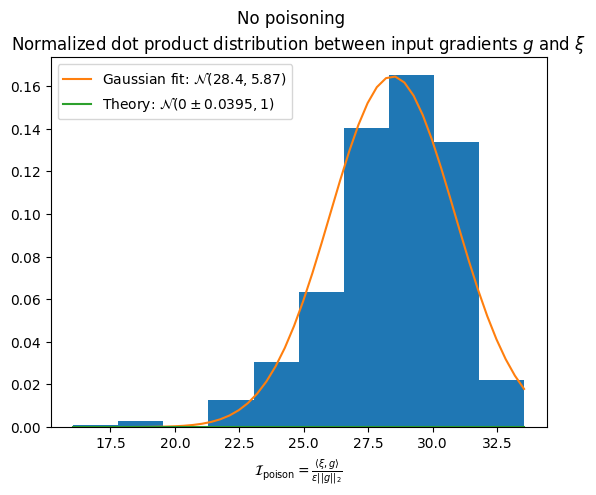

In [ ]:
evaluate_unlearning(net, base_set, noise, noise_std, CrossEntropyLoss(reduction='none'), method='No poisoning')

Explanation from Pawelczyk et al.: since we explicitly chose the noise to be roughly collinear to the input gradients, the quantity $I_z = \frac{{\langle \xi, g_z \rangle}}{{\varepsilon ||g_z||_2}} \approx \frac{{\langle \xi, \xi \rangle}}{{\varepsilon ||\xi||_2}}$ follows a $\chi^2 (d)$ distribution where $d = 32 \times 32$, so $\mathbb{E}[I_z] \approx \sqrt{\frac{32 \times 32 }{2}} \approx 27$.

In practice $\xi$ is not exactly collinear to $g_z$ due to gaussian noise, so $I_z$ ends up being a mix of gaussian and $\chi^2$.

### Data poisoning

We train the model on the corrupted dataset with 1.3 % poisons.

In [ ]:
poisoned_net = deepcopy(net)
train_loop(poisoned_net, corrupted_loader, criterion, optimizer, epochs=1)
test_loop(poisoned_net, test_loader, criterion)

[1,   200] loss: 0.620
[1,   400] loss: 0.609
[1,   600] loss: 0.625
Finished Training
Test accuracy on 10000 samples: 77 %
Average loss: 0.68


However, the model accuracy is rather high on the test set even if the adversarial examples seem completely wrong.

### Gaussian unlearning evaluation

We demonstrate that gradient ascent and NegGrad+ fail to remove the influence of these poisons.
We use the GUS test from Pawelczyk et al. This is an heuristic since the noise is not truly gaussian.

#### No unlearning

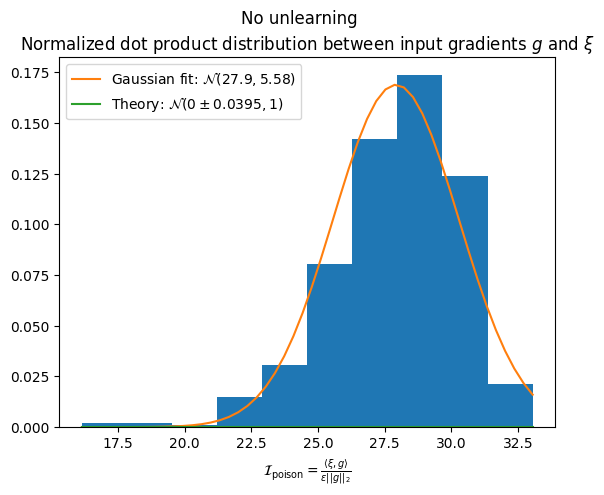

In [ ]:
evaluate_unlearning(poisoned_net, base_set, noise, noise_std, CrossEntropyLoss(reduction='none'), method='No unlearning')

Learning the poisons decreased the GUS towards negative infinity, which is coherent with the experiments from Pawelczyk et al. (although the poisons have been targeted so the GUS is very biased here).

#### Machine unlearning methods

In [ ]:
def gradient_ascent_unlearning(corrupted_model: nn.Module, unlearn_epochs=4, lr=1e-5):
    unlearner = deepcopy(corrupted_model)
    opt_ga = SGD(unlearner.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    # FIXME: test data used as validation data
    gradient_ascent(unlearner, adversarial_loader, test_loader, criterion, opt_ga, epochs=unlearn_epochs)
    return unlearner

Train epochs:   0%|          | 0/4 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/640 [00:00<?, ?it/s]

Train loop: 100%|██████████| 640/640 [00:00<00:00, 1686.87it/s, avg_loss=-4.73]


Test epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 10000/10000 [00:02<00:00, 4548.24it/s, avg_loss=-0.72]


Train loop:   0%|          | 0/640 [00:00<?, ?it/s]

Train loop: 100%|██████████| 640/640 [00:00<00:00, 1681.07it/s, avg_loss=-4.75]


Train loop:   0%|          | 0/640 [00:00<?, ?it/s]

Train loop: 100%|██████████| 640/640 [00:00<00:00, 1676.04it/s, avg_loss=-4.77]


Test epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 10000/10000 [00:02<00:00, 4535.75it/s, avg_loss=-0.833]


Train loop:   0%|          | 0/640 [00:00<?, ?it/s]

Train loop: 100%|██████████| 640/640 [00:00<00:00, 1678.42it/s, avg_loss=-4.79]


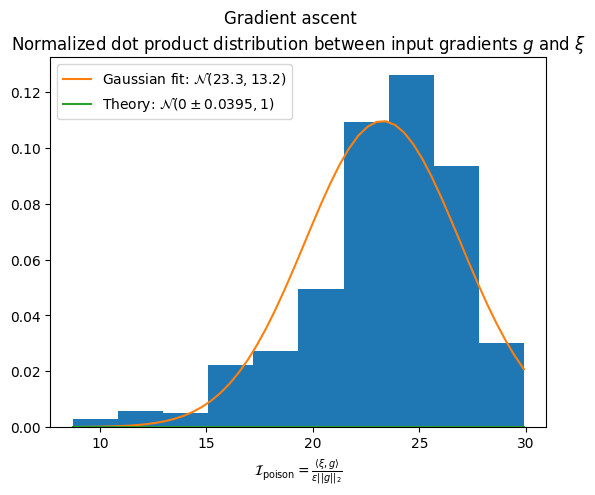

In [ ]:
unlearner = gradient_ascent_unlearning(poisoned_net)
evaluate_unlearning(unlearner, base_set, noise, noise_std, CrossEntropyLoss(reduction='none'), method='Gradient ascent')

In [ ]:
def gradient_ascent_unlearning_rev_order(corrupted_model: nn.Module, unlearn_epochs=1, lr=1e-5):
    adv_loader_rev_order = DataLoader(
        adversarial_set,
        batch_size=batch_size,
        # Reverse the order of the examples
        sampler=range(len(adversarial_set) - 1, -1, -1),
    )
    unlearner = deepcopy(corrupted_model)
    opt_ga = SGD(unlearner.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    # FIXME: test data used as validation data
    gradient_ascent(unlearner, adv_loader_rev_order, test_loader, criterion, opt_ga, epochs=unlearn_epochs)
    return unlearner

Train epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Train loop:   0%|          | 0/640 [00:00<?, ?it/s]

Train loop: 100%|██████████| 640/640 [00:00<00:00, 1689.76it/s, avg_loss=-4.73]


Test epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Test epoch: 100%|██████████| 10000/10000 [00:02<00:00, 4418.54it/s, avg_loss=-0.72]


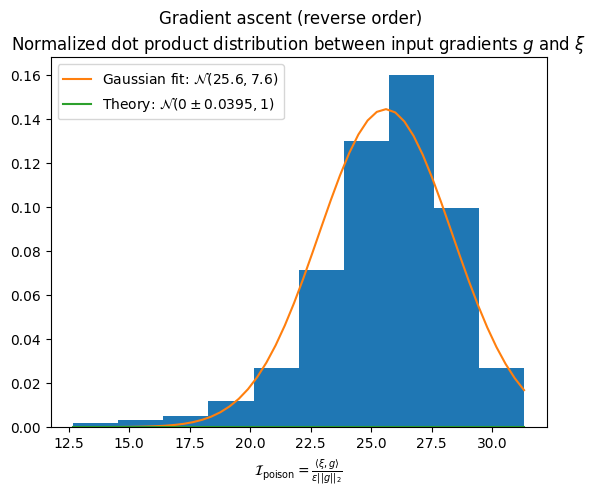

In [ ]:
unlearner = gradient_ascent_unlearning_rev_order(poisoned_net)
evaluate_unlearning(unlearner, base_set, noise, noise_std, CrossEntropyLoss(reduction='none'), method='Gradient ascent (reverse order)')

In [ ]:
def neg_grad_plus_unlearning(corrupted_model, unlearn_epochs=4, lr=1e-3, beta=0.995):
    unlearner = deepcopy(corrupted_model)
    opt_ngp = SGD(unlearner.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    for _ in range(unlearn_epochs):
        neg_grad_plus(
            unlearner, clean_loader, adversarial_loader,
            criterion, opt_ngp,
            beta=beta, keep_pbars=False,
        )
    return unlearner

NegGrad+:   0%|          | 0/640 [00:00<?, ?it/s]

NegGrad+:   0%|          | 0/640 [00:00<?, ?it/s]

NegGrad+:   0%|          | 0/640 [00:00<?, ?it/s]

NegGrad+:   0%|          | 0/640 [00:00<?, ?it/s]

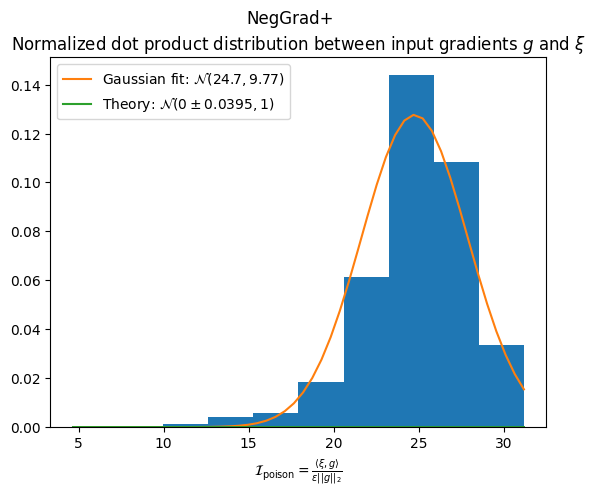

In [ ]:
unlearner = neg_grad_plus_unlearning(poisoned_net)
evaluate_unlearning(unlearner, base_set, noise, noise_std, CrossEntropyLoss(reduction='none'), method='NegGrad+')

## The gradients are not continous w.r.t the model

We also show that Banach's fixed point theorem does not apply. This is because there are multiple fixed points, which are local minima.

NOTE: possibly already shown by previous observations

TODO: clarify

## Inverting a single gradient step is hard

TODO: prove that $\Phi_t$ is not injective with gradient descent experiment (starting from a random model and from $\theta_{t+1}$)

## Gradient steps do not commute

We show that different shuffles of a dataset yield diverging models.